In [17]:
#Import libraries
from pyhive import presto
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import h3
from datetime import datetime
from functools import reduce
import json
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [18]:
#Define presto credentials
presto_host = 'presto-gateway.serving.data.plectrum.dev'
presto_port = '80'
username = 'aditya.bhattar@rapido.bike'

#Create connection to presto host
connection = presto.connect(presto_host,presto_port,username = username)

In [22]:
hsr_lower_zone = pd.read_csv('lower_half_full.csv')
hsr_lower_zone_hexes = hsr_lower_zone['pickup_location_hex_8'].unique().tolist()
hsr_lower_zone_inner = pd.read_csv('lower_half_inner.csv')
hsr_lower_zone_inner_hexes = hsr_lower_zone_inner['pickup_location_hex_8'].unique().tolist()
print(hsr_lower_zone_hexes)
print(len(hsr_lower_zone_hexes))

['886189255bfffff', '88618924edfffff', '88618925cbfffff', '88618925d1fffff', '886189242bfffff', '886189242dfffff', '8861892421fffff', '8861892425fffff', '8861892423fffff', '8861892405fffff', '8861892429fffff', '88618924e5fffff', '8861892427fffff', '886189240dfffff', '8861892435fffff', '8861892465fffff', '88618925ddfffff', '8861892467fffff', '88618925d3fffff', '8861892553fffff', '886189246bfffff', '88618925c9fffff', '8861892461fffff', '88618925d9fffff', '8861892463fffff', '8861892437fffff', '88618925dbfffff', '88618924e7fffff', '886189243dfffff', '8861892433fffff', '8861892403fffff', '886189243bfffff', '8861892445fffff', '8861892439fffff', '8861892415fffff', '8861892431fffff', '8861892519fffff', '8861892447fffff', '88618924adfffff', '8861892407fffff', '8861892469fffff', '886189246dfffff', '8861892401fffff']
43


In [5]:
#Query data from order_logs_snapshot

q = """
select order_id, accept_to_pickup_distance, city_name, customer_location_hex_8, customer_location_latitude, 
customer_location_longitude, hhmmss, hour, quarter_hour, service_obj_service_name, time_bucket, weekday, yyyymmdd,
order_status, cancel_reason, eta, map_riders, pickup_location_hex_8
from orders.order_logs_snapshot
where yyyymmdd >= '20230420'
and yyyymmdd <= '20230517'
and city_name in ('Bangalore')
and service_obj_service_name = 'Auto'
and pickup_location_hex_8 in ('8861892545fffff', '886189254bfffff', '8861892541fffff', '88618920d5fffff', '8861892099fffff', '8861892085fffff', '886189255dfffff',
 '8861892087fffff', '8861892543fffff', '88618920e3fffff', '88618920bbfffff', '886189254dfffff', '88618920dbfffff', '8861892729fffff', '8861892089fffff',
  '8861892093fffff', '886189209bfffff', '88618920abfffff', '8861892767fffff', '8861892081fffff', '88618920a9fffff', '886189208dfffff', '886189272dfffff',
   '8861892723fffff', '8861892083fffff', '8861892549fffff', '88618920b9fffff', '8861892091fffff', '8861892095fffff', '8861892721fffff', '88618920b1fffff',
    '8861892727fffff', '886189209dfffff', '8861892097fffff', '8861892725fffff', '88618920bdfffff')
and hour in ('17', '18', '19', '20', '21')
"""


#Load data into pandas table
df_copy = pd.read_sql(q, connection)

In [6]:
#Create a copy of the df retrived from presto
df = df_copy.copy()
df.head()

,order_id,accept_to_pickup_distance,city_name,customer_location_hex_8,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,eta,map_riders,pickup_location_hex_8
0,645bb07f8dbcb75a89aae2fd,NaN,Bangalore,8861892087fffff,12.946529,77.716103,202559,20,2015,Auto,20:00,3,20230510,customerCancelled,order cancelled before rider accepted,5.0,"[""60e40ba709aa997a3940deb7"",""630736be81735c01d...",8861892087fffff
1,64579f7d7121e01872b5b31d,0.010,Bangalore,8861892555fffff,12.923977,77.665297,182421,18,1815,Auto,18:00,7,20230507,dropped,None,2.0,"[""63294d90d0aa91192373a63b"",""6106012f74addc0ab...",8861892541fffff
2,6457a22326c18569edfe91b0,NaN,Bangalore,88618920bdfffff,12.955954,77.712656,183539,18,1830,Auto,18:59,7,20230507,expired,None,0.0,"[""5c63d423f2edc73367578dc8"",""61eabe39ebef822ea...",88618920bdfffff
3,6457a295a105c02a77c31d8e,NaN,Bangalore,88618920c5fffff,12.933932,77.740825,183733,18,1830,Auto,18:59,7,20230507,customerCancelled,order cancelled before rider accepted,6.0,"[""632c0be64bdbff40122cc1b4"",""631468bfa0c4b7eae...",88618920b9fffff
4,6457a482f0610b49a557caed,0.129,Bangalore,88618920bbfffff,12.951315,77.699333,184546,18,1845,Auto,18:59,7,20230507,dropped,None,2.0,"[""59a14fcdf2b6708059497e8b"",""631468bfa0c4b7eae...",88618920bbfffff


In [7]:
#View the dataset
df_captain = df.copy()
df_captain.head()

,order_id,accept_to_pickup_distance,city_name,customer_location_hex_8,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,eta,map_riders,pickup_location_hex_8
0,645bb07f8dbcb75a89aae2fd,NaN,Bangalore,8861892087fffff,12.946529,77.716103,202559,20,2015,Auto,20:00,3,20230510,customerCancelled,order cancelled before rider accepted,5.0,"[""60e40ba709aa997a3940deb7"",""630736be81735c01d...",8861892087fffff
1,64579f7d7121e01872b5b31d,0.010,Bangalore,8861892555fffff,12.923977,77.665297,182421,18,1815,Auto,18:00,7,20230507,dropped,None,2.0,"[""63294d90d0aa91192373a63b"",""6106012f74addc0ab...",8861892541fffff
2,6457a22326c18569edfe91b0,NaN,Bangalore,88618920bdfffff,12.955954,77.712656,183539,18,1830,Auto,18:59,7,20230507,expired,None,0.0,"[""5c63d423f2edc73367578dc8"",""61eabe39ebef822ea...",88618920bdfffff
3,6457a295a105c02a77c31d8e,NaN,Bangalore,88618920c5fffff,12.933932,77.740825,183733,18,1830,Auto,18:59,7,20230507,customerCancelled,order cancelled before rider accepted,6.0,"[""632c0be64bdbff40122cc1b4"",""631468bfa0c4b7eae...",88618920b9fffff
4,6457a482f0610b49a557caed,0.129,Bangalore,88618920bbfffff,12.951315,77.699333,184546,18,1845,Auto,18:59,7,20230507,dropped,None,2.0,"[""59a14fcdf2b6708059497e8b"",""631468bfa0c4b7eae...",88618920bbfffff


In [8]:
#Filter only on the hexes needed
df_filter_level1 = df
df_filter_level1['count'] = 1
df_filter_level1['date'] = df_filter_level1['yyyymmdd'].astype(str).apply(lambda x: x[6:])

In [9]:
#Create a new column for cancel_reason to identify OCARA
df_filter_level1['new_cancel_reason'] = np.where(df_filter_level1['order_status'] == 'customerCancelled',
 np.where(df_filter_level1['cancel_reason'] == 'order cancelled before rider accepted', 'COBRA',
 np.where(df_filter_level1['cancel_reason'] == 'Order cancelled before rider was mapped', 'COBRM', 'OCARA')), 'no_cancellation')

In [10]:
#Check if the order is expiry_mapped or expiry_unmapped
df_filter_level1['expiry_type'] = np.where(df_filter_level1['order_status'] == 'expired',
 np.where(df_filter_level1['map_riders'] == '[]', 'expiry_unmapped', 'expiry_mapped'), 'no_expiry')
df_filter_level1['final_order_status'] = np.where(df_filter_level1['order_status'] == 'customerCancelled', df_filter_level1['new_cancel_reason'],
np.where(df_filter_level1['order_status'] == 'expired', df_filter_level1['expiry_type'], df_filter_level1['order_status']))

In [11]:
#Metrics_pivot
metrics_pivot = pd.pivot_table(df_filter_level1, index = ['yyyymmdd'], columns = 'final_order_status',
 values = 'count', aggfunc = 'sum', fill_value=0).reset_index().rename_axis(None, axis=1)
metrics_pivot['total'] = metrics_pivot[['COBRA', 'COBRM', 'OCARA', 'aborted', 'dropped', 'expiry_mapped', 'expiry_unmapped']].sum(axis = 1)
metrics_pivot['OCARA%'] = round(metrics_pivot['OCARA']/metrics_pivot['total'], 4)
metrics_pivot['COBRA%'] = round(metrics_pivot['COBRA']/metrics_pivot['total'], 4)
metrics_pivot['COBRM%'] = round(metrics_pivot['COBRM']/metrics_pivot['total'], 4)
metrics_pivot['G2N'] = round(metrics_pivot['dropped']/metrics_pivot['total'], 4)
metrics_pivot['expiry_mapped%'] = round(metrics_pivot['expiry_mapped']/metrics_pivot['total'], 4)
if 'expiry_unmapped' in metrics_pivot.columns:
    metrics_pivot['Stockout%'] = round(metrics_pivot['expiry_unmapped']/metrics_pivot['total'], 4)
else:
    metrics_pivot['Stockout%'] = 0
metrics_df = metrics_pivot[['yyyymmdd', 'OCARA%', 'COBRA%', 'COBRM%', 'G2N', 'expiry_mapped%', 'Stockout%', 'total']]
metrics_df.head()

,yyyymmdd,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total
0,20230420,0.0263,0.2773,0.0034,0.0615,0.6271,0.0039,12313
1,20230421,0.0217,0.2933,0.0037,0.0526,0.6254,0.0027,16376
2,20230422,0.0329,0.3076,0.0024,0.0805,0.5734,0.0029,12233
3,20230423,0.0456,0.3035,0.0066,0.1143,0.5186,0.0104,8458
4,20230424,0.0502,0.2933,0.0014,0.1279,0.5255,0.0009,6927


In [12]:
#Get the average ETA and FM
df_dropped = df_filter_level1[df_filter_level1['final_order_status'] == 'dropped']
fm = df_dropped.groupby(['yyyymmdd'])['accept_to_pickup_distance'].mean().reset_index()
fm = fm.rename(columns = {'accept_to_pickup_distance':'FM'})
eta = df_dropped.groupby(['yyyymmdd'])['eta'].mean().reset_index()
metrics_df = metrics_df.merge(fm, on = ['yyyymmdd'], how = 'left')
metrics_df = metrics_df.merge(eta, on = ['yyyymmdd'], how = 'left')
metrics_df.head()

,yyyymmdd,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta
0,20230420,0.0263,0.2773,0.0034,0.0615,0.6271,0.0039,12313,8.379385,3.990753
1,20230421,0.0217,0.2933,0.0037,0.0526,0.6254,0.0027,16376,5.277550,3.794425
2,20230422,0.0329,0.3076,0.0024,0.0805,0.5734,0.0029,12233,0.980439,3.924873
3,20230423,0.0456,0.3035,0.0066,0.1143,0.5186,0.0104,8458,8.612633,3.796277
4,20230424,0.0502,0.2933,0.0014,0.1279,0.5255,0.0009,6927,9.323559,3.895034


In [16]:
metrics_df

,yyyymmdd,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta
0,20230420,0.0263,0.2773,0.0034,0.0615,0.6271,0.0039,12313,8.379385,3.990753
1,20230421,0.0217,0.2933,0.0037,0.0526,0.6254,0.0027,16376,5.277550,3.794425
2,20230422,0.0329,0.3076,0.0024,0.0805,0.5734,0.0029,12233,0.980439,3.924873
3,20230423,0.0456,0.3035,0.0066,0.1143,0.5186,0.0104,8458,8.612633,3.796277
4,20230424,0.0502,0.2933,0.0014,0.1279,0.5255,0.0009,6927,9.323559,3.895034
5,20230425,0.0361,0.3044,0.0019,0.0980,0.5575,0.0013,8501,0.981200,3.930372
6,20230426,0.0305,0.2884,0.0030,0.0683,0.6073,0.0023,12540,5.307984,3.865654
7,20230427,0.0321,0.2945,0.0015,0.0885,0.5818,0.0008,10687,6.888120,4.006342
8,20230428,0.0187,0.2826,0.0094,0.0405,0.6371,0.0113,19180,3.364537,3.666667
9,20230429,0.0247,0.2874,0.0022,0.0524,0.6275,0.0052,16243,11.844596,3.654524


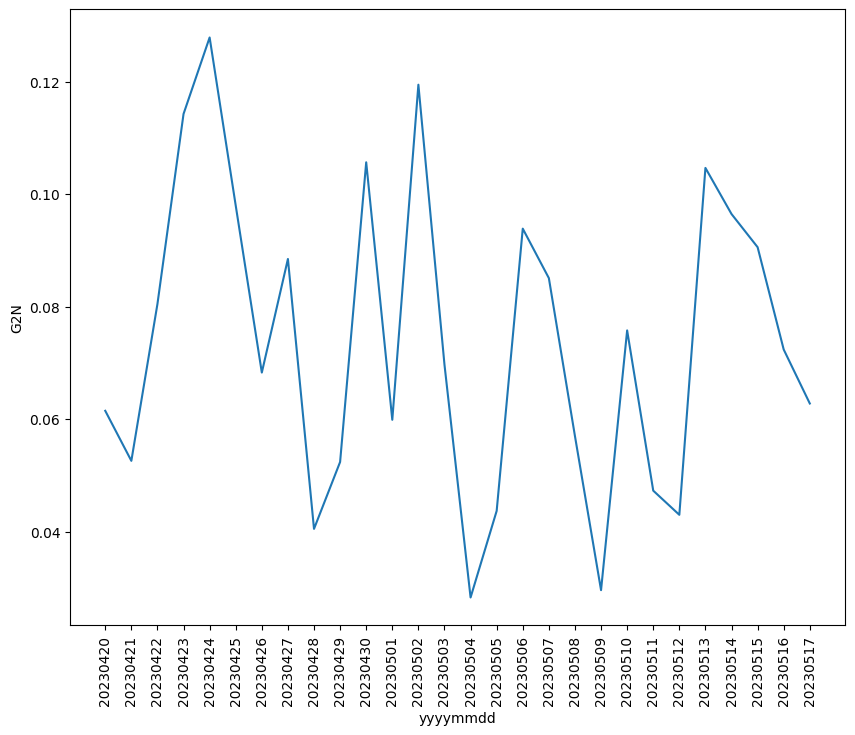

In [15]:
plt.figure(figsize = (10, 8))
sns.lineplot(x = metrics_df['yyyymmdd'], y = metrics_df['G2N'])
plt.xticks(rotation = 90)
plt.show()

In [11]:
#Get the number of captains by cluster
#Make columns for second and minute and date
df_captain['second'] = df_captain['hhmmss'].astype(str).apply(lambda x: x[4:])
df_captain['minute'] = df_captain['hhmmss'].astype(str).apply(lambda x: x[2:4])
df_captain['date'] = df_captain['yyyymmdd'].astype(str).apply(lambda x: x[6:])
df_captain['map_riders'] = df_captain['map_riders'].apply(lambda x: json.loads(x))
df_captain = df_captain[df_captain['map_riders'].apply(lambda x: len(x)) > 0]
df_captain['15_sec_batch'] = pd.cut(df_captain['second'].astype(int), bins = [-1, 15, 30, 45, 61], labels = ['0-15', '15-30', '30-45', '45-60'])

#Get the riders mapped in 20_sec_windows
df_captains_20_sec = df_captain.groupby(['yyyymmdd', 'hour', 'minute', '15_sec_batch'])['map_riders'].apply(list).reset_index()

#Get the number of captains in a single list
map_riders = []
df_captains_20_sec = df_captains_20_sec.dropna()
for x in df_captains_20_sec['map_riders'].values:
    riders = [item for sublist in x for item in sublist]
    map_riders.append(riders)

unique_captains = []
for x in map_riders:
    unique_captains_list = []
    for y in x:
        if y in unique_captains_list:
            continue
        else:
            unique_captains_list.append(y)
    unique_captains.append(unique_captains_list)

df_captains_20_sec['total_captains'] = unique_captains

#Get the number of captains in each batch
df_captains_20_sec['number_of_captains'] = df_captains_20_sec['total_captains'].apply(lambda x: len(x))

#Get the average number of captains coming in each 20_second_window
df_20_sec_average = df_captains_20_sec.groupby(['yyyymmdd', 'hour'])['number_of_captains'].median().reset_index()

#Merge the hourly captains and 20_sec_captains with the metrics table
metrics_df = metrics_df.merge(df_20_sec_average, on = ['yyyymmdd', 'hour'], how = 'left')
metrics_df.head()

,yyyymmdd,hour,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta,number_of_captains
0,20230410,00,0.3367,0.2551,0.0000,0.3929,0.0102,0.0,196,1.260364,4.857143,25.0
1,20230410,01,0.2917,0.0833,0.0000,0.5833,0.0417,0.0,48,1.633357,5.857143,23.0
2,20230410,02,0.4167,0.1111,0.0278,0.4167,0.0278,0.0,36,1.453200,6.133333,13.0
3,20230410,03,0.2903,0.2581,0.1613,0.2419,0.0323,0.0,62,1.426933,5.066667,8.0
4,20230410,04,0.2000,0.2889,0.0000,0.4222,0.0889,0.0,45,2.018526,6.105263,5.5


In [12]:
#Query data from order_logs_immutable for calculating TTC

q = """
select order_id, accept_to_pickup_distance, captain_location_hex_8, captain_location_latitude,
captain_location_longitude, city_name, customer_location_hex_8, drop_location_hex_8, drop_location_latitude, drop_location_longitude, customer_location_latitude, 
customer_location_longitude, hhmmss, hour, quarter_hour, service_obj_service_name, time_bucket, weekday, yyyymmdd,
order_status, cancel_reason, updated_epoch, event_type, pickup_location_hex_8
from orders.order_logs_immutable
where yyyymmdd >= '20230410'
and yyyymmdd <= '20230423'
and city_name in ('Bangalore')
and service_obj_service_name = 'Link'
and event_type in ('customer_cancelled', 'order_requested', 'accepted')
and pickup_location_hex_8 in ('8861892545fffff', '886189254bfffff', '8861892541fffff', '88618920d5fffff', '8861892099fffff', '8861892085fffff', '886189255dfffff',
 '8861892087fffff', '8861892543fffff', '88618920e3fffff', '88618920bbfffff', '886189254dfffff', '88618920dbfffff', '8861892729fffff', '8861892089fffff',
  '8861892093fffff', '886189209bfffff', '88618920abfffff', '8861892767fffff', '8861892081fffff', '88618920a9fffff', '886189208dfffff', '886189272dfffff',
   '8861892723fffff', '8861892083fffff', '8861892549fffff', '88618920b9fffff', '8861892091fffff', '8861892095fffff', '8861892721fffff', '88618920b1fffff',
    '8861892727fffff', '886189209dfffff', '8861892097fffff', '8861892725fffff', '88618920bdfffff')
"""

#Load data into pandas table
df_ttc_copy = pd.read_sql(q, connection)

In [13]:
#Load and view dataset
df_ttc = df_ttc_copy.copy()
df_ttc['timestamp'] = df_ttc['updated_epoch'].apply(lambda x: datetime.fromtimestamp(x/1000))
df_ttc = df_ttc.sort_values(by = 'timestamp')
df_ttc.head()

,order_id,accept_to_pickup_distance,captain_location_hex_8,captain_location_latitude,captain_location_longitude,city_name,customer_location_hex_8,drop_location_hex_8,drop_location_latitude,drop_location_longitude,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,updated_epoch,event_type,pickup_location_hex_8,timestamp
382996,643304506b042d72ccd30197,NaN,,NaN,NaN,Bangalore,88618920b1fffff,8861892cc7fffff,13.037849,77.617166,12.952156,77.701286,000040,00,0000,Link,00:00,1,20230410,requested,None,1681065040845,order_requested,88618920b1fffff,2023-04-10 00:00:40.845
420498,643304506b042d72ccd30197,NaN,88618920b1fffff,12.955117,77.700855,Bangalore,88618920b1fffff,8861892cc7fffff,13.037849,77.617166,12.952156,77.701286,000040,00,0000,Link,00:00,1,20230410,onTheWay,None,1681065049505,accepted,88618920b1fffff,2023-04-10 00:00:49.505
392950,64330485ddfc230482e14b7d,NaN,,NaN,NaN,Bangalore,8861892097fffff,886189209dfffff,12.936372,77.705558,12.942347,77.697276,000133,00,0000,Link,00:00,1,20230410,requested,None,1681065093894,order_requested,8861892097fffff,2023-04-10 00:01:33.894
405472,643304946b042d72ccd301de,NaN,,NaN,NaN,Bangalore,8861892723fffff,8861892cb3fffff,13.058752,77.581215,12.908463,77.684993,000148,00,0000,Link,00:00,1,20230410,requested,None,1681065108607,order_requested,8861892723fffff,2023-04-10 00:01:48.607
397125,64330495373d85214287ba30,NaN,,NaN,NaN,Bangalore,88618920b9fffff,8861892097fffff,12.940368,77.696079,12.945477,77.706825,000149,00,0000,Link,00:00,1,20230410,requested,None,1681065109254,order_requested,88618920b9fffff,2023-04-10 00:01:49.254


In [14]:
#Create a column to identify OCARA, COBRA and COBRM
df_ttc['new_cancel_reason'] = np.where(df_ttc['event_type'] == 'customer_cancelled',
 np.where(df_ttc['cancel_reason'] == 'order cancelled before rider accepted', 'COBRA',
 np.where(df_ttc['cancel_reason'] == 'Order cancelled before rider was mapped', 'COBRM', 'OCARA')), 'no_cancellation')
df_ttc.head()

,order_id,accept_to_pickup_distance,captain_location_hex_8,captain_location_latitude,captain_location_longitude,city_name,customer_location_hex_8,drop_location_hex_8,drop_location_latitude,drop_location_longitude,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,updated_epoch,event_type,pickup_location_hex_8,timestamp,new_cancel_reason
382996,643304506b042d72ccd30197,NaN,,NaN,NaN,Bangalore,88618920b1fffff,8861892cc7fffff,13.037849,77.617166,12.952156,77.701286,000040,00,0000,Link,00:00,1,20230410,requested,None,1681065040845,order_requested,88618920b1fffff,2023-04-10 00:00:40.845,no_cancellation
420498,643304506b042d72ccd30197,NaN,88618920b1fffff,12.955117,77.700855,Bangalore,88618920b1fffff,8861892cc7fffff,13.037849,77.617166,12.952156,77.701286,000040,00,0000,Link,00:00,1,20230410,onTheWay,None,1681065049505,accepted,88618920b1fffff,2023-04-10 00:00:49.505,no_cancellation
392950,64330485ddfc230482e14b7d,NaN,,NaN,NaN,Bangalore,8861892097fffff,886189209dfffff,12.936372,77.705558,12.942347,77.697276,000133,00,0000,Link,00:00,1,20230410,requested,None,1681065093894,order_requested,8861892097fffff,2023-04-10 00:01:33.894,no_cancellation
405472,643304946b042d72ccd301de,NaN,,NaN,NaN,Bangalore,8861892723fffff,8861892cb3fffff,13.058752,77.581215,12.908463,77.684993,000148,00,0000,Link,00:00,1,20230410,requested,None,1681065108607,order_requested,8861892723fffff,2023-04-10 00:01:48.607,no_cancellation
397125,64330495373d85214287ba30,NaN,,NaN,NaN,Bangalore,88618920b9fffff,8861892097fffff,12.940368,77.696079,12.945477,77.706825,000149,00,0000,Link,00:00,1,20230410,requested,None,1681065109254,order_requested,88618920b9fffff,2023-04-10 00:01:49.254,no_cancellation


In [15]:
#Filter the df only zone1
df_ttc_filter = df_ttc
df_ttc_filter.head()

,order_id,accept_to_pickup_distance,captain_location_hex_8,captain_location_latitude,captain_location_longitude,city_name,customer_location_hex_8,drop_location_hex_8,drop_location_latitude,drop_location_longitude,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,updated_epoch,event_type,pickup_location_hex_8,timestamp,new_cancel_reason
382996,643304506b042d72ccd30197,NaN,,NaN,NaN,Bangalore,88618920b1fffff,8861892cc7fffff,13.037849,77.617166,12.952156,77.701286,000040,00,0000,Link,00:00,1,20230410,requested,None,1681065040845,order_requested,88618920b1fffff,2023-04-10 00:00:40.845,no_cancellation
420498,643304506b042d72ccd30197,NaN,88618920b1fffff,12.955117,77.700855,Bangalore,88618920b1fffff,8861892cc7fffff,13.037849,77.617166,12.952156,77.701286,000040,00,0000,Link,00:00,1,20230410,onTheWay,None,1681065049505,accepted,88618920b1fffff,2023-04-10 00:00:49.505,no_cancellation
392950,64330485ddfc230482e14b7d,NaN,,NaN,NaN,Bangalore,8861892097fffff,886189209dfffff,12.936372,77.705558,12.942347,77.697276,000133,00,0000,Link,00:00,1,20230410,requested,None,1681065093894,order_requested,8861892097fffff,2023-04-10 00:01:33.894,no_cancellation
405472,643304946b042d72ccd301de,NaN,,NaN,NaN,Bangalore,8861892723fffff,8861892cb3fffff,13.058752,77.581215,12.908463,77.684993,000148,00,0000,Link,00:00,1,20230410,requested,None,1681065108607,order_requested,8861892723fffff,2023-04-10 00:01:48.607,no_cancellation
397125,64330495373d85214287ba30,NaN,,NaN,NaN,Bangalore,88618920b9fffff,8861892097fffff,12.940368,77.696079,12.945477,77.706825,000149,00,0000,Link,00:00,1,20230410,requested,None,1681065109254,order_requested,88618920b9fffff,2023-04-10 00:01:49.254,no_cancellation


In [16]:
#Filter df on the columns needed
df_filter = df_ttc_filter[['order_id', 'pickup_location_hex_8', 'hour', 'yyyymmdd', 'timestamp', 'event_type', 'new_cancel_reason']]

#Filter on the respective order_status
df_cobra = df_filter[df_filter['new_cancel_reason'] == 'COBRA']
df_ocara = df_filter[df_filter['new_cancel_reason'] == 'OCARA']
df_cobrm = df_filter[df_filter['new_cancel_reason'] == 'COBRM']
df_order_created = df_filter[df_filter['event_type'] == 'order_requested']
df_accepted = df_filter[df_filter['event_type'] == 'accepted']

#Sort the dfs by timestamp
df_cobra = df_cobra.sort_values(by = 'timestamp', ascending=True)
df_cobra = df_cobra.drop_duplicates(subset='order_id')

df_ocara = df_ocara.sort_values(by = 'timestamp', ascending=True)
df_ocara = df_ocara.drop_duplicates(subset='order_id')

df_cobrm = df_cobrm.sort_values(by = 'timestamp', ascending=True)
df_cobrm = df_cobrm.drop_duplicates(subset='order_id')

df_accepted = df_accepted.sort_values(by = 'timestamp', ascending=True)
df_accepted = df_accepted.drop_duplicates(subset='order_id')

#Change the column names
df_cobra = df_cobra[['order_id', 'new_cancel_reason', 'timestamp']]
df_cobra.columns = ['order_id', 'COBRA', 'timestamp_cobra']

df_cobrm = df_cobrm[['order_id', 'new_cancel_reason', 'timestamp']]
df_cobrm.columns = ['order_id', 'COBRM', 'timestamp_cobrm']

df_ocara = df_ocara[['order_id', 'new_cancel_reason', 'timestamp']]
df_ocara.columns = ['order_id', 'OCARA', 'timestamp_ocara']

df_accepted = df_accepted[['order_id', 'event_type', 'timestamp']]
df_accepted.columns = ['order_id', 'Accepted', 'timestamp_accepted']

#Merge the dfs together
dfs_to_merge = [df_order_created, df_cobra, df_cobrm, df_ocara, df_accepted]
df_final = reduce(lambda  left, right: pd.merge(left, right,on=['order_id'], how='left'), dfs_to_merge).fillna('NA')
df_final.head()

,order_id,pickup_location_hex_8,hour,yyyymmdd,timestamp,event_type,new_cancel_reason,COBRA,timestamp_cobra,COBRM,timestamp_cobrm,OCARA,timestamp_ocara,Accepted,timestamp_accepted
0,643304506b042d72ccd30197,88618920b1fffff,00,20230410,2023-04-10 00:00:40.845,order_requested,no_cancellation,NA,NA,NA,NA,OCARA,2023-04-10 00:11:11.936000,accepted,2023-04-10 00:00:49.505000
1,64330485ddfc230482e14b7d,8861892097fffff,00,20230410,2023-04-10 00:01:33.894,order_requested,no_cancellation,NA,NA,NA,NA,OCARA,2023-04-10 00:03:48.912000,accepted,2023-04-10 00:03:23.644000
2,643304946b042d72ccd301de,8861892723fffff,00,20230410,2023-04-10 00:01:48.607,order_requested,no_cancellation,COBRA,2023-04-10 00:01:51.353000,NA,NA,NA,NA,NA,NA
3,64330495373d85214287ba30,88618920b9fffff,00,20230410,2023-04-10 00:01:49.254,order_requested,no_cancellation,NA,NA,NA,NA,OCARA,2023-04-10 00:10:36.752000,accepted,2023-04-10 00:01:59.065000
4,643304aaddfc230482e14bb9,8861892081fffff,00,20230410,2023-04-10 00:02:10.447,order_requested,no_cancellation,COBRA,2023-04-10 00:02:15.417000,NA,NA,NA,NA,NA,NA


In [17]:
#Filter on the respective order_status
df_cobra = df_final[df_final['COBRA'] == 'COBRA']
df_ocara = df_final[df_final['OCARA'] == 'OCARA']
df_cobrm = df_final[df_final['COBRM'] == 'COBRM']
df_accepted = df_final[df_final['Accepted'] == 'accepted']

#Calculate TTC for cobrm, ocara, and cobra and tta
df_cobra['ttc_cobra'] = pd.to_datetime(df_cobra['timestamp_cobra']) - pd.to_datetime(df_cobra['timestamp'])
df_cobra['ttc_cobra'] = df_cobra['ttc_cobra'].apply(lambda x: x.total_seconds())

df_cobrm['ttc_cobrm'] = pd.to_datetime(df_cobrm['timestamp_cobrm']) - pd.to_datetime(df_cobrm['timestamp'])
df_cobrm['ttc_cobrm'] = df_cobrm['ttc_cobrm'].apply(lambda x: x.total_seconds())

df_ocara['ttc_ocara'] = pd.to_datetime(df_ocara['timestamp_ocara']) - pd.to_datetime(df_ocara['timestamp'])
df_ocara['ttc_ocara'] = df_ocara['ttc_ocara'].apply(lambda x: x.total_seconds())

df_accepted['tta'] = pd.to_datetime(df_accepted['timestamp_accepted']) - pd.to_datetime(df_accepted['timestamp'])
df_accepted['tta'] = df_accepted['tta'].apply(lambda x: x.total_seconds())

#Filter only on the new columns made
df_cobra = df_cobra[['order_id', 'ttc_cobra']]
df_cobrm = df_cobrm[['order_id', 'ttc_cobrm']]
df_ocara = df_ocara[['order_id', 'ttc_ocara']]
df_accepted = df_accepted[['order_id', 'tta']]

#Merge the dfs together
dfs_to_merge = [df_final, df_cobra, df_cobrm, df_ocara, df_accepted]
df_final = reduce(lambda  left, right: pd.merge(left, right,on=['order_id'], how='left'), dfs_to_merge)
df_final.head()

,order_id,pickup_location_hex_8,hour,yyyymmdd,timestamp,event_type,new_cancel_reason,COBRA,timestamp_cobra,COBRM,timestamp_cobrm,OCARA,timestamp_ocara,Accepted,timestamp_accepted,ttc_cobra,ttc_cobrm,ttc_ocara,tta
0,643304506b042d72ccd30197,88618920b1fffff,00,20230410,2023-04-10 00:00:40.845,order_requested,no_cancellation,NA,NA,NA,NA,OCARA,2023-04-10 00:11:11.936000,accepted,2023-04-10 00:00:49.505000,NaN,NaN,631.091,8.660
1,64330485ddfc230482e14b7d,8861892097fffff,00,20230410,2023-04-10 00:01:33.894,order_requested,no_cancellation,NA,NA,NA,NA,OCARA,2023-04-10 00:03:48.912000,accepted,2023-04-10 00:03:23.644000,NaN,NaN,135.018,109.750
2,643304946b042d72ccd301de,8861892723fffff,00,20230410,2023-04-10 00:01:48.607,order_requested,no_cancellation,COBRA,2023-04-10 00:01:51.353000,NA,NA,NA,NA,NA,NA,2.746,NaN,NaN,NaN
3,64330495373d85214287ba30,88618920b9fffff,00,20230410,2023-04-10 00:01:49.254,order_requested,no_cancellation,NA,NA,NA,NA,OCARA,2023-04-10 00:10:36.752000,accepted,2023-04-10 00:01:59.065000,NaN,NaN,527.498,9.811
4,643304aaddfc230482e14bb9,8861892081fffff,00,20230410,2023-04-10 00:02:10.447,order_requested,no_cancellation,COBRA,2023-04-10 00:02:15.417000,NA,NA,NA,NA,NA,NA,4.970,NaN,NaN,NaN


In [18]:
#Create a date column
df_final['date'] = df_final['yyyymmdd'].astype(str).apply(lambda x: x[6:])
df_final['count'] = 1

#Get average ttc, tta
df_cobra_grouped = df_final[df_final['COBRA'] == 'COBRA'].groupby(['yyyymmdd', 'hour'])['ttc_cobra'].median().reset_index()
df_ocara_grouped = df_final[df_final['OCARA'] == 'OCARA'].groupby(['yyyymmdd', 'hour'])['ttc_ocara'].median().reset_index()
df_cobrm_grouped = df_final[df_final['COBRM'] == 'COBRM'].groupby(['yyyymmdd', 'hour'])['ttc_cobrm'].median().reset_index()
df_accepted_grouped = df_final[df_final['Accepted'] == 'accepted'].groupby(['yyyymmdd', 'hour'])['tta'].median().reset_index()

#Merge the dfs together
dfs_to_merge = [df_cobra_grouped, df_cobrm_grouped, df_ocara_grouped, df_accepted_grouped]
df_metrics_final = reduce(lambda  left, right: pd.merge(left, right,on=['yyyymmdd', 'hour'], how='left'), dfs_to_merge).fillna('NA')
df_metrics_final.head()

,yyyymmdd,hour,ttc_cobra,ttc_cobrm,ttc_ocara,tta
0,20230410,00,30.8520,NA,293.9400,12.3770
1,20230410,01,29.4990,NA,334.2420,11.3710
2,20230410,02,16.2855,66.352,178.0860,9.4950
3,20230410,03,86.7055,101.7845,312.9215,11.7645
4,20230410,04,104.4680,NA,240.8480,19.8205


In [19]:
#Merge ttc with metrics_df
metrics_df = metrics_df.merge(df_metrics_final, on = ['yyyymmdd', 'hour'], how = 'left')
metrics_df.head()

,yyyymmdd,hour,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta,number_of_captains,ttc_cobra,ttc_cobrm,ttc_ocara,tta
0,20230410,00,0.3367,0.2551,0.0000,0.3929,0.0102,0.0,196,1.260364,4.857143,25.0,30.8520,NA,293.9400,12.3770
1,20230410,01,0.2917,0.0833,0.0000,0.5833,0.0417,0.0,48,1.633357,5.857143,23.0,29.4990,NA,334.2420,11.3710
2,20230410,02,0.4167,0.1111,0.0278,0.4167,0.0278,0.0,36,1.453200,6.133333,13.0,16.2855,66.352,178.0860,9.4950
3,20230410,03,0.2903,0.2581,0.1613,0.2419,0.0323,0.0,62,1.426933,5.066667,8.0,86.7055,101.7845,312.9215,11.7645
4,20230410,04,0.2000,0.2889,0.0000,0.4222,0.0889,0.0,45,2.018526,6.105263,5.5,104.4680,NA,240.8480,19.8205


In [11]:
#Query data from order_logs_snapshot

q = """
select order_id, accept_to_pickup_distance, captain_location_hex_8, captain_location_latitude,
captain_location_longitude, city_name, customer_location_hex_8, drop_location_hex_8, drop_location_latitude, drop_location_longitude, customer_location_latitude, 
customer_location_longitude, hhmmss, hour, quarter_hour, service_obj_service_name, time_bucket, weekday, yyyymmdd,
order_status, cancel_reason, updated_epoch, event_type, captain_id, spd_fraud_flag, pickup_location_hex_8, estimated_accept_to_pickup_distance
from orders.order_logs_immutable
where yyyymmdd in ('20230420', '20230421', '20230422', '20230427', '20230428', '20230429')
and service_obj_service_name = 'Auto'
and event_type in ('accepted', 'rider_busy', 'rider_reject')
and pickup_location_hex_8 in ('886189255bfffff', '88618924edfffff', '88618925cbfffff', '88618925d1fffff', '886189242bfffff', '886189242dfffff', '8861892421fffff',
 '8861892425fffff', '8861892423fffff', '8861892405fffff', '8861892429fffff', '88618924e5fffff', '8861892427fffff', '886189240dfffff', '8861892435fffff',
   '8861892465fffff', '88618925ddfffff', '8861892467fffff', '88618925d3fffff', '8861892553fffff', '886189246bfffff', '88618925c9fffff', '8861892461fffff',
     '88618925d9fffff', '8861892463fffff', '8861892437fffff', '88618925dbfffff', '88618924e7fffff', '886189243dfffff', '8861892433fffff', '8861892403fffff',
       '886189243bfffff', '8861892445fffff', '8861892439fffff', '8861892415fffff', '8861892431fffff', '8861892519fffff', '8861892447fffff', '88618924adfffff',
         '8861892407fffff', '8861892469fffff', '886189246dfffff', '8861892401fffff')
and hour in ('17', '18', '19', '20', '21')
"""

#Load data into pandas table
df_apr_copy = pd.read_sql(q, connection)

In [12]:
#Load and view dataset
df_apr = df_apr_copy.copy()
df_apr.head()

,order_id,accept_to_pickup_distance,captain_location_hex_8,captain_location_latitude,captain_location_longitude,city_name,customer_location_hex_8,drop_location_hex_8,drop_location_latitude,drop_location_longitude,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,updated_epoch,event_type,captain_id,spd_fraud_flag,pickup_location_hex_8,estimated_accept_to_pickup_distance
0,64412e9c35cd510b35f4a0a6,NaN,88618925d9fffff,12.907274,77.600917,Bangalore,88618925d9fffff,8861892437fffff,12.914745,77.609040,12.913446,77.598763,175252,17,1745,Auto,17:59,4,20230420,new,None,1681993411520,rider_reject,6268320579756267df429a02,None,88618925d9fffff,1307.6
1,64412d3509a3c154ad1e2ee1,NaN,88618925d9fffff,12.912341,77.599996,Bangalore,88618925d9fffff,8861892433fffff,12.908336,77.605789,12.907443,77.600800,174653,17,1745,Auto,17:59,4,20230420,new,None,1681993043800,rider_busy,62947696f30e73275b32979d,None,88618925d9fffff,747.4
2,64412f2fba488a7a74a23d35,NaN,8861892429fffff,12.905075,77.642704,Bangalore,886189242dfffff,8861892513fffff,12.936641,77.628833,12.909761,77.647308,175519,17,1745,Auto,17:59,4,20230420,onTheWay,None,1681993631475,accepted,5af1e44866a16e223320d4bc,None,886189242dfffff,1092.9
3,64412f85d1e1ab77e4e6794d,NaN,8861892433fffff,12.903527,77.608909,Bangalore,8861892431fffff,88618925d7fffff,12.928742,77.591221,12.905464,77.611557,175645,17,1745,Auto,17:59,4,20230420,new,None,1681993619493,rider_reject,60e7efeb09aa993aac42ef9d,None,8861892431fffff,463.5
4,64412f8667e55167dd9ed62d,NaN,8861892423fffff,12.908237,77.627849,Bangalore,886189243dfffff,8861892463fffff,12.896095,77.641277,12.906317,77.623093,175646,17,1745,Auto,17:59,4,20230420,new,None,1681993647435,rider_reject,63ff41b37993128663d8f5b1,None,886189243dfffff,1478.7


In [13]:
df_apr.groupby(['yyyymmdd'])['estimated_accept_to_pickup_distance'].median().reset_index()

,yyyymmdd,estimated_accept_to_pickup_distance
0,20230420,1198.2
1,20230421,1179.0
2,20230422,1221.8
3,20230427,1278.9
4,20230428,1246.0
5,20230429,1232.6


In [14]:
df_apr.groupby(['yyyymmdd'])['estimated_accept_to_pickup_distance'].quantile(0.9).reset_index()

,yyyymmdd,estimated_accept_to_pickup_distance
0,20230420,1853.0
1,20230421,1848.6
2,20230422,1858.7
3,20230427,1863.4
4,20230428,1854.4
5,20230429,1846.0


In [21]:
#Query data from order_logs_snapshot

q = """
select order_id, accept_to_pickup_distance, captain_location_hex_8, captain_location_latitude,
captain_location_longitude, city_name, customer_location_hex_8, drop_location_hex_8, drop_location_latitude, drop_location_longitude, customer_location_latitude, 
customer_location_longitude, hhmmss, hour, quarter_hour, service_obj_service_name, time_bucket, weekday, yyyymmdd, pickup_location_latitude, pickup_location_longitude,
order_status, cancel_reason, updated_epoch, event_type, captain_id, spd_fraud_flag, pickup_location_hex_8, estimated_accept_to_pickup_distance, map_riders
from orders.order_logs_immutable
where yyyymmdd in ('20230427', '20230428', '20230429')
and service_obj_service_name = 'Auto'
and event_type in ('order_create', 'order_refreshed')
and pickup_location_hex_8 in ('886189255bfffff', '88618924edfffff', '88618925cbfffff', '88618925d1fffff', '886189242bfffff', '886189242dfffff', '8861892421fffff',
 '8861892425fffff', '8861892423fffff', '8861892405fffff', '8861892429fffff', '88618924e5fffff', '8861892427fffff', '886189240dfffff', '8861892435fffff',
   '8861892465fffff', '88618925ddfffff', '8861892467fffff', '88618925d3fffff', '8861892553fffff', '886189246bfffff', '88618925c9fffff', '8861892461fffff',
     '88618925d9fffff', '8861892463fffff', '8861892437fffff', '88618925dbfffff', '88618924e7fffff', '886189243dfffff', '8861892433fffff', '8861892403fffff',
       '886189243bfffff', '8861892445fffff', '8861892439fffff', '8861892415fffff', '8861892431fffff', '8861892519fffff', '8861892447fffff', '88618924adfffff',
         '8861892407fffff', '8861892469fffff', '886189246dfffff', '8861892401fffff')
and hour in ('17', '18', '19', '20', '21')
"""

#Load data into pandas table
df_apr_copy = pd.read_sql(q, connection)

In [23]:
df_apr_copy[(df_apr_copy['pickup_location_hex_8'].isin(hsr_lower_zone_inner_hexes)) & 
            (df_apr_copy['captain_location_hex_8'].isin(hsr_lower_zone_hexes))].to_csv('lower_zone_pings.csv', index = False)

In [19]:
#Load and view dataset
df_apr = df_apr_copy.copy()
df_apr.head()

,order_id,accept_to_pickup_distance,captain_location_hex_8,captain_location_latitude,captain_location_longitude,city_name,customer_location_hex_8,drop_location_hex_8,drop_location_latitude,drop_location_longitude,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,updated_epoch,event_type,captain_id,spd_fraud_flag,pickup_location_hex_8,estimated_accept_to_pickup_distance,map_riders
0,644a996ebc92e73d2d24ce9b,1.287,8861892433fffff,12.905442,77.602748,Bangalore,88618925ddfffff,8861892437fffff,12.909052,77.609152,12.915071,77.606071,211902,21,2115,Auto,21:00,4,20230427,new,Other,1682610725197,order_refreshed,62a8d7167d796711cee8d14c,None,88618925ddfffff,1686.0,"[""5b052fe2c417360b44a82075"",""5c94b1b58c352421e..."
1,644a999d377eaf1d04c35aa6,NaN,886189255bfffff,12.912085,77.651828,Bangalore,8861892421fffff,88618925c5fffff,12.935193,77.624481,12.912068,77.638054,211949,21,2115,Auto,21:00,4,20230427,new,None,1682610633972,order_refreshed,59fecf2e0af9b81959e09bc0,None,8861892421fffff,1757.8,"[""63524bfa3faf2e2799267ee5"",""629fa0479f3c1873a..."
2,644a9a1cdf41c0543f20d4d9,NaN,,NaN,NaN,Bangalore,886189255bfffff,8861892465fffff,12.899725,77.655380,12.909956,77.651810,212156,21,2115,Auto,21:00,4,20230427,new,None,1682610727506,order_refreshed,,None,886189255bfffff,NaN,"[""6121e51634b93d287b2e823a"",""638ff3b81fc3fa68b..."
3,644a95e1df41c0543f20cf2f,NaN,88618924e5fffff,12.901046,77.600910,Bangalore,88618925d9fffff,88618924edfffff,12.892251,77.601862,12.907118,77.600995,210353,21,2100,Auto,21:00,4,20230427,new,None,1682609803818,order_refreshed,60e55fb4af791b6f2d8cfb5a,None,88618925d9fffff,1184.4,"[""62767af4398c2fcdc40eeeee"",""63ac265aafba97e9f..."
4,644a96b12a803956b6989409,NaN,,NaN,NaN,Bangalore,88618925d9fffff,88618924a1fffff,12.909035,77.578050,12.911698,77.598946,210721,21,2100,Auto,21:00,4,20230427,new,None,1682609841766,order_create,,None,88618925d9fffff,NaN,"[""60efd9dad417d42ac0786d9f"",""60e55fb4af791b6f2..."


In [20]:
#Get the number of captains mapped
df_apr['map_riders'] = df_apr['map_riders'].apply(lambda x: json.loads(x))
df_captains_mapped_grouped = df_apr.groupby(['yyyymmdd', 'order_id'])['map_riders'].apply(list).reset_index()
df_captains_mapped_grouped['map_riders'] = df_captains_mapped_grouped['map_riders'].apply(lambda x: list(set([item for sublist in x for item in sublist])))
master_list = []
for x in df_captains_mapped_grouped['map_riders']:
    captains_list = []
    for captain in x:
        if captain in captains_list:
            continue
        else:
            captains_list.append(captain)
    master_list.append(captains_list)
df_captains_mapped_grouped['map_riders'] = master_list
df_captains_mapped_grouped['number_of_mapped_captains'] = df_captains_mapped_grouped['map_riders'].apply(lambda x: len(x))
df_captains_mapped_grouped.head()

,yyyymmdd,order_id,map_riders,number_of_mapped_captains
0,20230420,644122381c6d14472f498524,"[605d4f1cb244dc5043d87c7f, 60f50900d417d49dfc7...",70
1,20230420,6441223a3382915e31cf0edd,"[6127872834b93dfaff322ba8, 6103bcc70ebda8169ce...",64
2,20230420,6441223e12923951fe2e57ae,"[63db4927bcb96d9d3b8fbd90, 5d1396ddddfc0234288...",174
3,20230420,6441223e1c6d14472f49852f,"[60f5299e8f3479123b19e60b, 60f50900d417d49dfc7...",57
4,20230420,6441223e246f7347ed4ee99a,"[63db4927bcb96d9d3b8fbd90, 5d1396ddddfc0234288...",170


In [21]:
df_captains_mapped_grouped.groupby(['yyyymmdd'])['number_of_mapped_captains'].median().reset_index()

,yyyymmdd,number_of_mapped_captains
0,20230420,33.0
1,20230421,29.0
2,20230422,24.0
3,20230427,33.0
4,20230428,31.0
5,20230429,23.0


In [22]:
df_captains_mapped_grouped.groupby(['yyyymmdd'])['number_of_mapped_captains'].quantile(0.9).reset_index()

,yyyymmdd,number_of_mapped_captains
0,20230420,52.0
1,20230421,51.0
2,20230422,38.0
3,20230427,56.0
4,20230428,56.0
5,20230429,43.0


In [22]:
#Create a count column
df_apr['count'] = 1

#Create a column to identify total pings and accepted ping
df_apr['total_pings'] = np.where(df_apr['event_type'].isin(['accepted', 'rider_busy', 'rider_reject']), 1, 0)
df_apr['accepted_pings'] = np.where(df_apr['event_type'].isin(['accepted']), 1, 0)
df_me = df_apr[(df_apr['order_status'] == 'dropped') & (df_apr['spd_fraud_flag'] != True)]

#Groupby on date and hour to get the APR and ME on an hourly basis
apr_hyderabad = df_apr.groupby(['yyyymmdd', 'hour'])[['total_pings', 'accepted_pings']].sum().reset_index()
apr_hyderabad['APR'] = round(apr_hyderabad['accepted_pings']/apr_hyderabad['total_pings'], 4)
me_hyderabad = df_me.groupby(['yyyymmdd', 'hour'])['order_id'].nunique().reset_index()
me_hyderabad = me_hyderabad.rename(columns={'order_id':'net_orders'})
apr_hyderabad = apr_hyderabad.merge(me_hyderabad, on = ['yyyymmdd', 'hour'], how = 'left')
apr_hyderabad['ME'] = round(apr_hyderabad['total_pings']/apr_hyderabad['net_orders'], 2)

#Merge APR and ME with metrics_df
metrics_df = metrics_df.merge(apr_hyderabad, on = ['yyyymmdd', 'hour'], how = 'left')
metrics_df.head()

,yyyymmdd,hour,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta,number_of_captains,ttc_cobra,ttc_cobrm,ttc_ocara,tta,total_pings,accepted_pings,APR,net_orders,ME
0,20230410,00,0.3367,0.2551,0.0000,0.3929,0.0102,0.0,196,1.260364,4.857143,25.0,30.8520,NA,293.9400,12.3770,761,174,0.2286,70,10.87
1,20230410,01,0.2917,0.0833,0.0000,0.5833,0.0417,0.0,48,1.633357,5.857143,23.0,29.4990,NA,334.2420,11.3710,157,58,0.3694,26,6.04
2,20230410,02,0.4167,0.1111,0.0278,0.4167,0.0278,0.0,36,1.453200,6.133333,13.0,16.2855,66.352,178.0860,9.4950,76,32,0.4211,14,5.43
3,20230410,03,0.2903,0.2581,0.1613,0.2419,0.0323,0.0,62,1.426933,5.066667,8.0,86.7055,101.7845,312.9215,11.7645,191,44,0.2304,15,12.73
4,20230410,04,0.2000,0.2889,0.0000,0.4222,0.0889,0.0,45,2.018526,6.105263,5.5,104.4680,NA,240.8480,19.8205,207,33,0.1594,18,11.50


In [23]:
#Query data to calculate gsr
q = """
select 
        pickup_location_hex_8, yyyymmdd, hour,
        count(distinct order_id) as Gross_Orders,
        count(case when (time_diff >=20 or time_diff is NULL) then customer_id end) as GSR,
        count(distinct case when event_type in ('dropped') and spd_fraud_flag != True then order_id end) as net_orders,
        (case when count(distinct case when event_type in ('dropped') and spd_fraud_flag != True then order_id end) = 0 then 0 else
        sum(case when event_type in ('accepted', 'rider_busy', 'rider_reject') then 1 else 0 end)
        /cast(count(distinct case when event_type in ('dropped') and spd_fraud_flag != True then order_id end) as real) end) as ME
from
(
select
        *, 
        date_diff('minute',  LAG(FROM_UNIXTIME(CAST(epoch AS double) /1000)) OVER(PARTITION BY yyyymmdd, hour, city_name, customer_id, order_type, customer_location_hex_8
        ORDER BY yyyymmdd, customer_id, city_name, customer_location_hex_8, order_type, epoch), FROM_UNIXTIME(CAST(epoch AS double) /1000)) as time_diff,
        date_diff('minute',  LAG(FROM_UNIXTIME(CAST(epoch AS double) /1000)) OVER(PARTITION BY yyyymmdd, hour, city_name, customer_id, order_type, order_status, customer_location_hex_8, spd_fraud_flag 
        ORDER BY yyyymmdd, customer_id, city_name, customer_location_hex_8, order_type, epoch) , FROM_UNIXTIME(CAST(epoch AS double) /1000)) as time_diff_drop
from
(
select 
    order_id, city_name, order_type, cancel_reason, yyyymmdd, customer_id, epoch, substr(hhmmss,1,2) as hour,
    row_number() over (partition by order_id order by updated_epoch desc) as Rank_1,
    
    event_type, order_status, captain_id, pickup_cluster, customer_location_hex_8, spd_fraud_flag, pickup_location_hex_8

from
    orders.order_logs_immutable 
where
    yyyymmdd >= '20230410'
    and yyyymmdd <= '20230423'
    and order_type IN ('app')
    and pickup_location_hex_8 in ('8861892545fffff', '886189254bfffff', '8861892541fffff', '88618920d5fffff', '8861892099fffff', '8861892085fffff', '886189255dfffff',
 '8861892087fffff', '8861892543fffff', '88618920e3fffff', '88618920bbfffff', '886189254dfffff', '88618920dbfffff', '8861892729fffff', '8861892089fffff',
  '8861892093fffff', '886189209bfffff', '88618920abfffff', '8861892767fffff', '8861892081fffff', '88618920a9fffff', '886189208dfffff', '886189272dfffff',
   '8861892723fffff', '8861892083fffff', '8861892549fffff', '88618920b9fffff', '8861892091fffff', '8861892095fffff', '8861892721fffff', '88618920b1fffff',
    '8861892727fffff', '886189209dfffff', '8861892097fffff', '8861892725fffff', '88618920bdfffff')
))
group by 1,2,3
"""

df_gsr_copy = pd.read_sql(q, connection)

In [24]:
#Create a copy of the dataset and view it
df_gsr = df_gsr_copy.copy()
df_gsr.head()

,pickup_location_hex_8,yyyymmdd,hour,Gross_Orders,GSR,net_orders,ME
0,8861892097fffff,20230420,21,120,88,40,32.200000
1,88618920bdfffff,20230420,05,4,2,1,5.000000
2,8861892097fffff,20230411,10,55,40,17,7.470588
3,8861892541fffff,20230411,07,16,15,11,3.727273
4,8861892549fffff,20230412,18,87,53,11,68.090910


In [25]:
#Calculate GSR2Net
df_gsr_grouped = df_gsr.groupby(['yyyymmdd', 'hour'])[['GSR', 'net_orders']].sum().reset_index()
df_gsr_grouped['GSR2Net'] = round(df_gsr_grouped['net_orders']/df_gsr_grouped['GSR'], 4)

#Merge GSR with metrics_df
metrics_df = metrics_df.merge(df_gsr_grouped[['yyyymmdd', 'hour', 'GSR', 'GSR2Net']], on = ['yyyymmdd', 'hour'], how = 'left')
metrics_df.head()

,yyyymmdd,hour,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta,number_of_captains,ttc_cobra,ttc_cobrm,ttc_ocara,tta,total_pings,accepted_pings,APR,net_orders,ME,GSR,GSR2Net
0,20230410,00,0.3367,0.2551,0.0000,0.3929,0.0102,0.0,196,1.260364,4.857143,25.0,30.8520,NA,293.9400,12.3770,761,174,0.2286,70,10.87,158,0.4430
1,20230410,01,0.2917,0.0833,0.0000,0.5833,0.0417,0.0,48,1.633357,5.857143,23.0,29.4990,NA,334.2420,11.3710,157,58,0.3694,26,6.04,44,0.5909
2,20230410,02,0.4167,0.1111,0.0278,0.4167,0.0278,0.0,36,1.453200,6.133333,13.0,16.2855,66.352,178.0860,9.4950,76,32,0.4211,14,5.43,32,0.4375
3,20230410,03,0.2903,0.2581,0.1613,0.2419,0.0323,0.0,62,1.426933,5.066667,8.0,86.7055,101.7845,312.9215,11.7645,191,44,0.2304,15,12.73,46,0.3261
4,20230410,04,0.2000,0.2889,0.0000,0.4222,0.0889,0.0,45,2.018526,6.105263,5.5,104.4680,NA,240.8480,19.8205,207,33,0.1594,18,11.50,38,0.4737


In [26]:
#Query data from supply_login_servicelevel_kpi
q = """
select
        location as pickup_location_hex_8, yyyymmdd, substr(hhmm, 1, 2) as hour,
        sum(case when cast(status AS varchar) IN ('2','3','6','7','8','10') then duration end) as login_time,
        sum(case when cast(status AS varchar) IN ('2') then duration end) as idle_time
from 
(select 
        a.*, city, cluster
        
from 
        hive.datasets.supplycursory_history a 
        left join datasets.city_cluster_hex b 
        on a.location = b.hex_id and a.resolution = cast(b.resolution as varchar)
where 
        yyyymmdd >= '20230410'
        and yyyymmdd <= '20230423'
        and city in ('Bangalore')
        and a.resolution = '8' 
        and service in ('link')
        and location in ('8861892545fffff', '886189254bfffff', '8861892541fffff', '88618920d5fffff', '8861892099fffff', '8861892085fffff', '886189255dfffff',
 '8861892087fffff', '8861892543fffff', '88618920e3fffff', '88618920bbfffff', '886189254dfffff', '88618920dbfffff', '8861892729fffff', '8861892089fffff',
  '8861892093fffff', '886189209bfffff', '88618920abfffff', '8861892767fffff', '8861892081fffff', '88618920a9fffff', '886189208dfffff', '886189272dfffff',
   '8861892723fffff', '8861892083fffff', '8861892549fffff', '88618920b9fffff', '8861892091fffff', '8861892095fffff', '8861892721fffff', '88618920b1fffff',
    '8861892727fffff', '886189209dfffff', '8861892097fffff', '8861892725fffff', '88618920bdfffff')
)
group by 1,2,3
"""

#Load data into pandas table
df_tse_copy = pd.read_sql(q, connection)

In [27]:
#Create a copy of the df and view it
df_tse = df_tse_copy.copy()
df_tse.head()

,pickup_location_hex_8,yyyymmdd,hour,login_time,idle_time
0,8861892549fffff,20230423,22,2542.0,194.0
1,886189209dfffff,20230421,10,15348.0,2201.0
2,8861892549fffff,20230423,19,6336.0,586.0
3,886189209dfffff,20230420,22,9417.0,2500.0
4,8861892549fffff,20230420,10,32339.0,17996.0


In [28]:
#Calculate time_spent_earning
df_tse_grouped = df_tse.groupby(['yyyymmdd', 'hour'])[['login_time', 'idle_time']].sum().reset_index()
df_tse_grouped['time_spent_earning'] = round((df_tse_grouped['login_time'] - df_tse_grouped['idle_time'])/df_tse_grouped['login_time'], 4)
df_tse_grouped.head()

,yyyymmdd,hour,login_time,idle_time,time_spent_earning
0,20230410,00,513318.0,289845.0,0.4354
1,20230410,01,330644.0,232282.0,0.2975
2,20230410,02,218709.0,174282.0,0.2031
3,20230410,03,125778.0,94549.0,0.2483
4,20230410,04,100042.0,70534.0,0.2950


In [29]:
#Merge GSR with metrics_df
metrics_df = metrics_df.merge(df_tse_grouped, on = ['yyyymmdd', 'hour'], how = 'left')
metrics_df.head()

,yyyymmdd,hour,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta,number_of_captains,ttc_cobra,ttc_cobrm,ttc_ocara,tta,total_pings,accepted_pings,APR,net_orders,ME,GSR,GSR2Net,login_time,idle_time,time_spent_earning
0,20230410,00,0.3367,0.2551,0.0000,0.3929,0.0102,0.0,196,1.260364,4.857143,25.0,30.8520,NA,293.9400,12.3770,761,174,0.2286,70,10.87,158,0.4430,513318.0,289845.0,0.4354
1,20230410,01,0.2917,0.0833,0.0000,0.5833,0.0417,0.0,48,1.633357,5.857143,23.0,29.4990,NA,334.2420,11.3710,157,58,0.3694,26,6.04,44,0.5909,330644.0,232282.0,0.2975
2,20230410,02,0.4167,0.1111,0.0278,0.4167,0.0278,0.0,36,1.453200,6.133333,13.0,16.2855,66.352,178.0860,9.4950,76,32,0.4211,14,5.43,32,0.4375,218709.0,174282.0,0.2031
3,20230410,03,0.2903,0.2581,0.1613,0.2419,0.0323,0.0,62,1.426933,5.066667,8.0,86.7055,101.7845,312.9215,11.7645,191,44,0.2304,15,12.73,46,0.3261,125778.0,94549.0,0.2483
4,20230410,04,0.2000,0.2889,0.0000,0.4222,0.0889,0.0,45,2.018526,6.105263,5.5,104.4680,NA,240.8480,19.8205,207,33,0.1594,18,11.50,38,0.4737,100042.0,70534.0,0.2950


In [30]:
#Create a copy of the dataset and view it
df_captains_mapped = df_copy.copy()
df_captains_mapped.head()

,order_id,accept_to_pickup_distance,city_name,customer_location_hex_8,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,eta,map_riders,pickup_location_hex_8
0,643bb6b1ee623a70eee720c4,1.507,Bangalore,8861892085fffff,12.947007,77.722290,141953,14,1415,Link,14:00,7,20230416,dropped,None,6.0,"[""63ee2f84e370d6dd6c59ef90"",""6162e9ef77c7e6b1e...",8861892085fffff
1,643bb89b6b8317383f414cab,1.853,Bangalore,88618920bbfffff,12.950012,77.701265,142803,14,1415,Link,14:00,7,20230416,dropped,None,8.0,"[""623dec2579d2674e4fb07f51"",""607a6153255e27cc6...",88618920bbfffff
2,643bbbf2e0382b532b65ba26,1.789,Bangalore,88618920b1fffff,12.956978,77.702780,144218,14,1430,Link,14:59,7,20230416,customerCancelled,Customer asked to cancel,7.0,"[""5e4b95927ea425a39b6cb910"",""63c8b353ec19f00c6...",88618920b1fffff
3,643bbcf8cac0523bb40a0e9f,1.583,Bangalore,886189254bfffff,12.919333,77.671005,144640,14,1445,Link,14:59,7,20230416,dropped,None,6.0,"[""63d1e080e00e30fe287716ef"",""606f124d7761609b7...",886189254bfffff
4,643bbdb8259b2f4d1a7b4cb9,NaN,Bangalore,88618920b1fffff,12.954740,77.700409,144952,14,1445,Link,14:59,7,20230416,customerCancelled,order cancelled before rider accepted,0.0,"[""63ff5aac24d5dc39dfcddaa9"",""5ca7164a54bc7263f...",88618920b1fffff


In [31]:
#Get the number of captains mapped
df_captains_mapped['map_riders'] = df_captains_mapped['map_riders'].apply(lambda x: json.loads(x))
df_captains_mapped_grouped = df_captains_mapped.groupby(['yyyymmdd', 'hour'])['map_riders'].apply(list).reset_index()
df_captains_mapped_grouped['map_riders'] = df_captains_mapped_grouped['map_riders'].apply(lambda x: list(set([item for sublist in x for item in sublist])))
master_list = []
for x in df_captains_mapped_grouped['map_riders']:
    captains_list = []
    for captain in x:
        if captain in captains_list:
            continue
        else:
            captains_list.append(captain)
    master_list.append(captains_list)
df_captains_mapped_grouped['map_riders'] = master_list
df_captains_mapped_grouped['number_of_mapped_captains'] = df_captains_mapped_grouped['map_riders'].apply(lambda x: len(x))
metrics_df = metrics_df.merge(df_captains_mapped_grouped[['yyyymmdd', 'hour', 'number_of_mapped_captains']], 
on = ['yyyymmdd', 'hour'], how = 'left')
metrics_df.head()

,yyyymmdd,hour,OCARA%,COBRA%,COBRM%,G2N,expiry_mapped%,Stockout%,total,FM,eta,number_of_captains,ttc_cobra,ttc_cobrm,ttc_ocara,tta,total_pings,accepted_pings,APR,net_orders,ME,GSR,GSR2Net,login_time,idle_time,time_spent_earning,number_of_mapped_captains
0,20230410,00,0.3367,0.2551,0.0000,0.3929,0.0102,0.0,196,1.260364,4.857143,25.0,30.8520,NA,293.9400,12.3770,761,174,0.2286,70,10.87,158,0.4430,513318.0,289845.0,0.4354,398
1,20230410,01,0.2917,0.0833,0.0000,0.5833,0.0417,0.0,48,1.633357,5.857143,23.0,29.4990,NA,334.2420,11.3710,157,58,0.3694,26,6.04,44,0.5909,330644.0,232282.0,0.2975,197
2,20230410,02,0.4167,0.1111,0.0278,0.4167,0.0278,0.0,36,1.453200,6.133333,13.0,16.2855,66.352,178.0860,9.4950,76,32,0.4211,14,5.43,32,0.4375,218709.0,174282.0,0.2031,120
3,20230410,03,0.2903,0.2581,0.1613,0.2419,0.0323,0.0,62,1.426933,5.066667,8.0,86.7055,101.7845,312.9215,11.7645,191,44,0.2304,15,12.73,46,0.3261,125778.0,94549.0,0.2483,69
4,20230410,04,0.2000,0.2889,0.0000,0.4222,0.0889,0.0,45,2.018526,6.105263,5.5,104.4680,NA,240.8480,19.8205,207,33,0.1594,18,11.50,38,0.4737,100042.0,70534.0,0.2950,62


In [32]:
metrics_df.to_csv('bangalore_bellandur_sourcing_metrics.csv', index = False)